# Homework 6. Mikhail Shadrin

Do the multiple regression analysis using the following variables from **data_games.dta**:

##### **Dependent variable**: 
`payment`

##### **Independent variables**: 
`payment_type`, `payment_method`, `crystalls_balance_before_buy`, `crystalls_bought`

##### Describe the model:
* Specify the regression equation.
* Assess the goodness-of-fit of the model (R-square, significance of the model);
* Which independent variables significantly influence the dependent variable (explain your answer)?
* Describe the relationship between each independent and the dependent variable.

##### Do the diagnostics of the model:
* Are the residuals normally distributed?
* Are there any outliers (standardized residuals greater than 3, or less that -3)?
* Test the multicollinearity and heteroscedasticity.

In [1]:
import pandas as pd

data = pd.read_stata("data/data_games.dta")
data

,id,pack_id,crystalls_balance_before_buy,crystalls_bought,country,payment,utc_timestamp,payment_type,payment_method
0,2.052791e+09,3.0,0.0,41.0,GB,644.0,1.414842e+09,offer,general
1,1.275033e+09,1.0,10.0,7.0,US,205.0,1.414814e+09,offer,general
2,2.000015e+14,2.0,2.0,14.0,US,514.0,1.414866e+09,regular,general
3,1.119068e+09,4.0,0.0,70.0,GB,1289.0,1.414917e+09,regular,general
4,2.000028e+14,3.0,0.0,30.0,US,1029.0,1.414946e+09,regular,general
...,...,...,...,...,...,...,...,...,...
105502,2.733727e+09,5.0,89.0,180.0,US,3088.0,1.417208e+09,offer,general
105503,3.292330e+09,6.0,190.0,210.0,US,5147.0,1.417295e+09,regular,general
105504,2.000062e+14,1.0,0.0,8.0,FR,205.0,1.417267e+09,offer,general
105505,2.000002e+14,2.0,1.0,14.0,DK,553.0,1.417314e+09,regular,general


For correct regression we need to find out whether we have categorial_variables and how we can transform them to a proper form

At first, let's have a look on distinct values for `payment_type` and `payment_method` columns

In [2]:
print("Payment type distinct values:\n{}\n".format(data.payment_type.value_counts()))
print("Payment method distinct values:\n{}".format(data.payment_method.value_counts()))

Payment type distinct values:
regular    91668
offer      13839
Name: payment_type, dtype: int64

Payment method distinct values:
general         103278
mobile            1673
fb_promotion       498
giftcard            58
Name: payment_method, dtype: int64


In [3]:
# Payment_type variable can be transformed to a int flag variable
data["payment_type_is_regular"] = [1 if payment_type == "regular" else 0 for payment_type in data["payment_type"]]

# Payment_method variable can be transformed to a group of int flags for each value of it
# payment_method_is_general considered to be a dummy variable, since we will not include it in dependent variables
# data["payment_method_is_general"] = [1 if payment_method == "general" else 0 for payment_method in data["payment_method"]]
data["payment_method_is_mobile"] = [1 if payment_method == "mobile" else 0 for payment_method in data["payment_method"]]
data["payment_method_is_fb_promotion"] = [1 if payment_method == "fb_promotion" else 0 for payment_method in data["payment_method"]]
data["payment_method_is_giftcard"] = [1 if payment_method == "giftcard" else 0 for payment_method in data["payment_method"]]

data

,id,pack_id,crystalls_balance_before_buy,crystalls_bought,country,payment,utc_timestamp,payment_type,payment_method,payment_type_is_regular,payment_method_is_mobile,payment_method_is_fb_promotion,payment_method_is_giftcard
0,2.052791e+09,3.0,0.0,41.0,GB,644.0,1.414842e+09,offer,general,0,0,0,0
1,1.275033e+09,1.0,10.0,7.0,US,205.0,1.414814e+09,offer,general,0,0,0,0
2,2.000015e+14,2.0,2.0,14.0,US,514.0,1.414866e+09,regular,general,1,0,0,0
3,1.119068e+09,4.0,0.0,70.0,GB,1289.0,1.414917e+09,regular,general,1,0,0,0
4,2.000028e+14,3.0,0.0,30.0,US,1029.0,1.414946e+09,regular,general,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105502,2.733727e+09,5.0,89.0,180.0,US,3088.0,1.417208e+09,offer,general,0,0,0,0
105503,3.292330e+09,6.0,190.0,210.0,US,5147.0,1.417295e+09,regular,general,1,0,0,0
105504,2.000062e+14,1.0,0.0,8.0,FR,205.0,1.417267e+09,offer,general,0,0,0,0
105505,2.000002e+14,2.0,1.0,14.0,DK,553.0,1.417314e+09,regular,general,1,0,0,0


In [26]:
import numpy as np
import statsmodels.api as sm

independent_var = data["payment"]

no_const_dependent_vars = data[["payment_type_is_regular", "payment_method_is_mobile", 
                       "payment_method_is_fb_promotion", "payment_method_is_giftcard",
                       "crystalls_balance_before_buy", "crystalls_bought"]]

#Our model needs an intercept so we add a column of 1s
dependent_vars = sm.add_constant(no_const_dependent_vars)
dependent_vars

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,payment_type_is_regular,payment_method_is_mobile,payment_method_is_fb_promotion,payment_method_is_giftcard,crystalls_balance_before_buy,crystalls_bought
0,1.0,0,0,0,0,0.0,41.0
1,1.0,0,0,0,0,10.0,7.0
2,1.0,1,0,0,0,2.0,14.0
3,1.0,1,0,0,0,0.0,70.0
4,1.0,1,0,0,0,0.0,30.0
...,...,...,...,...,...,...,...
105502,1.0,0,0,0,0,89.0,180.0
105503,1.0,1,0,0,0,190.0,210.0
105504,1.0,0,0,0,0,0.0,8.0
105505,1.0,1,0,0,0,1.0,14.0


In [5]:
# Let's train our regression model
model = sm.OLS(independent_var, dependent_vars).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                payment   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                 4.985e+04
Date:                Sat, 14 Mar 2020   Prob (F-statistic):               0.00
Time:                        02:20:14   Log-Likelihood:            -8.4391e+05
No. Observations:              105507   AIC:                         1.688e+06
Df Residuals:                  105500   BIC:                         1.688e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             42.9763      6.529      6.583      0.000      30.180      55.772
payment_type_is_regular          395.6248      6.622     59.741      0.000     382.645     408.605
payment_method_is_mobile        -598.9345     17.757    -33.730      0.000    -633.738    -564.131
payment_method_is_fb_promotion  -256.3561     32.389     -7.915      0.000    -319.838    -192.874
payment_method_is_giftcard     -2176.7170     94.630    -23.003      0.000   -2362.190   -1991.244
crystalls_balance_before_buy      -0.6067      0.024    -25.075      0.000      -0.654      -0.559
crystalls_bought                  16.1742      0.030    543.506      0.000      16.116      16.233
==============================================================================
Omnibus:                   100306.419   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         22721624.067
Skew:                          -4.039   Prob(JB):                         0.00
Kurtosis:                      74.437   Cond. No.                     4.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 1. Specify the regression equation

In [6]:
equation = "payment = {:.4f}".format(model.params[0])
for (param, index) in zip(model.params[1:], model.params.index[1:]):
    equation = equation + " + {:.4f} * {}".format(param, index)

print(equation)

payment = 42.9763 + 395.6248 * payment_type_is_regular + -598.9345 * payment_method_is_mobile + -256.3561 * payment_method_is_fb_promotion + -2176.7170 * payment_method_is_giftcard + -0.6067 * crystalls_balance_before_buy + 16.1742 * crystalls_bought


### 2. Assess the goodness-of-fit of the model (R-square, significance of the model);

In [7]:
print("R^2 = {:.4f}".format(model.rsquared))
print("F statistics for R^2 = {:.4f}".format(model.f_pvalue))

R^2 = 0.7393
F statistics for R^2 = 0.0000


This means that the model is statistically significant on the 95% level of significance and describes 73.93% of observations

### 3. Which independent variables significantly influence the dependent variable (explain your answer)?

In [8]:
def is_statistically_significant(param_p_value):
    if param_p_value < 0.05:
        return 'statistically significant'
    else:
        return 'not statistically significant'
    
for i in range(1, len(model.params)):
    print("Parameter {} with p-value={:.3f} is {}".format(model.params.index[i], model.pvalues[i], is_statistically_significant(model.pvalues[i])))

Parameter payment_type_is_regular with p-value=0.000 is statistically significant
Parameter payment_method_is_mobile with p-value=0.000 is statistically significant
Parameter payment_method_is_fb_promotion with p-value=0.000 is statistically significant
Parameter payment_method_is_giftcard with p-value=0.000 is statistically significant
Parameter crystalls_balance_before_buy with p-value=0.000 is statistically significant
Parameter crystalls_bought with p-value=0.000 is statistically significant


### 4. Describe the relationship between each independent and the dependent variable.

1. Increase of current crystall balance by 1 decreases the payment by 0.607
2. Each bought crystall increases the payment by 16.17 in avreage
3. Regular payment type is likely to increase payment by 395.62
4. Fb promotion, mobile or giftcard payment methods are likely to decrease payment size by 598.93, 256.36, 2176.72 respectively

Since, we may suppose that payments with regular payment type and general payment method are most likely to bring the greatest profit, rather than other offered payment type and other payment methods.
Also biggest payments are held by players with low crystall balance but big volumes of crystall bought

### 5. Are the residuals normally distributed?

To test whether the residuals are normally distributed we define following hypothesis:
* **H0**: the distribution of residuals is *not* significantly different form the normal distribution
* **H1**: the distribution of residuals is significantly different form the normal distribution

To proof or reject H0 hypothesis we apply Kolmogorov-Smirnov test

In [9]:
from scipy.stats import kstest

kstest_statistics_pvalue = kstest(model.resid, 'norm').pvalue
print('P-value: ', kstest_statistics_pvalue)

P-value:  0.0


Since, p-value is less than 0.05, we reject H0 and assume that the residuals are not distributed normally

P.S. We also could use built-in in OLS `Jarque-Bera test` results (test which checks rather skewness and kurtosis of distribution are similar to normal or not)

|||
|---|---|
|Jarque-Bera (JB)|	22721624.067|
|Prob(JB)|	0.00|

As we can see, p-value for this test is also 0.0. Since, we reject H0 which stands for similarity between this distribution and normal


### 6. Are there any outliers (standardized residuals greater than 3, or less that -3)?

In [10]:
print("There are {} possible outliners".format((abs(model.resid_pearson) > 3.0).sum()))

There are 1778 possible outliners


In [12]:
c, p = infl.cooks_distance
plt.figure(figsize=(8,5))
plt.title("Cook's distance plot for the residuals", fontsize=16)
plt.stem(np.arange(len(c)), c, markerfmt=",", use_line_collection=True)
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

### 7. Test the multicollinearity and heteroscedasticity.

#### For heteroscedasticity we can use Breusch-Pagan and White tests

For both of these tests hypothesis are:

`H₀: δ₁ = δ₂ = … = δk=0`

`H1: δ₁ … ≠ 0`

In [18]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

white_test = het_white(model.resid,  model.model.exog)
bp_test = het_breuschpagan(model.resid,  model.model.exog)

print(dict(zip(labels, bp_test)))
print(dict(zip(labels, white_test)))

{'LM Statistic': 21976.247385594575, 'LM-Test p-value': 0.0, 'F-Statistic': 4626.02899055006, 'F-Test p-value': 0.0}
{'LM Statistic': 64510.798853921064, 'LM-Test p-value': 0.0, 'F-Statistic': 9764.433647734752, 'F-Test p-value': 0.0}


Since, both tests' p-values are less than 0.05 we can reject the H0 hypothesis of homoskedasticity.

#### For multicollinearity we can create collinearity plot or inspect VIF Factors

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vifs = [variance_inflation_factor(model.model.exog, i).round(1) for i in range(model.model.exog.shape[1])]

vif_table = pd.DataFrame()
vif_table["VIF Factor"] = vifs[1:]
vif_table["features"] = model.params.index[1:]
vif_table

,VIF Factor,features
0,1.0,payment_type_is_regular
1,1.0,payment_method_is_mobile
2,1.0,payment_method_is_fb_promotion
3,1.0,payment_method_is_giftcard
4,1.0,crystalls_balance_before_buy
5,1.0,crystalls_bought


There is no multicollinearity, as no VIF Factor has value greater than 5. WE can see this in a plot below

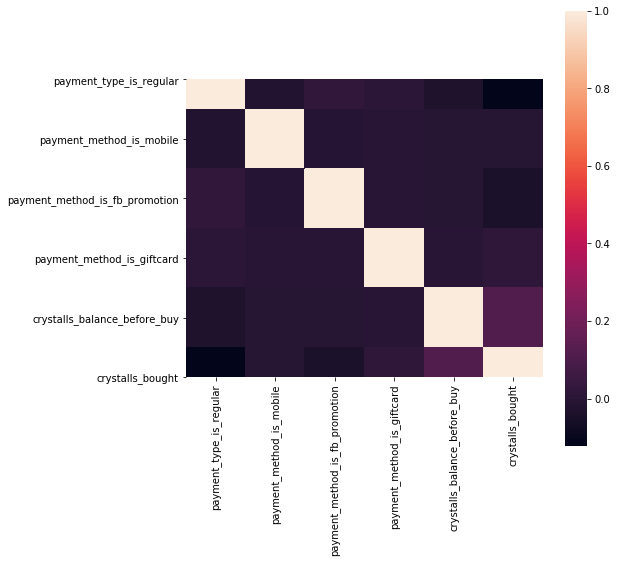

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.heatmap(no_const_dependent_vars.corr(), square = True)
plt.show()